# Lightning Flash Dataset: EDA with K-Means Clustering

In [15]:
# 1.Import libraries
import duckdb as db
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set() # plot styling
import warnings

# from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
warnings.filterwarnings('ignore')

In [16]:
# 2.Load dataset - db connections
conn = db.connect("glmFlash.db") # Path to db file
lat_df = conn.execute("SELECT * FROM tbl_flash_lat;").df() # latitude co-ordinates
lon_df = conn.execute("SELECT * FROM tbl_flash_lon;").df() # longitude co-ordinates
print(lat_df.describe(), "\n")
print(lon_df.describe())

               lat
count  6569.000000
mean      5.516261
std      22.829315
min     -50.141575
25%     -16.144665
50%       8.039109
75%      20.779776
max      53.227520 

               lon
count  6569.000000
mean    -65.223890
std     125.687053
min    -179.278630
25%    -151.467160
50%    -103.610510
75%     -93.345110
max     179.837630


In [17]:
# 3.Preprocess the data - Cleaning up the data
# assuming each flash point corresponds to a lightning discharge?
lat_df.drop(lat_df.columns[[2]],axis=1,inplace=True)  # drop file name
lon_df.drop(lon_df.columns[[2]],axis=1,inplace=True)  # drop file name
print(lat_df.info(), "\n")
print(lon_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6569 entries, 0 to 6568
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ts_date  6569 non-null   datetime64[ns]
 1   lat      6569 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 102.8 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6569 entries, 0 to 6568
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ts_date  6569 non-null   datetime64[ns]
 1   lon      6569 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 102.8 KB
None


In [18]:
# remove duplicates
lat_df.drop_duplicates(subset=['ts_date'], inplace=True)
lon_df.drop_duplicates(subset=['ts_date'], inplace=True)
print(lat_df.ts_date.value_counts(), "\n")
print(lon_df.ts_date.value_counts())
# join dataframes
geo_df = lon_df.join(lat_df.set_index('ts_date'), on='ts_date')
geo_df.size
# dataset time window
start = geo_df.ts_date.min()
end = geo_df.ts_date.max()
print(f"Start: {start}; End: {end}")

2023-01-01 00:12:22.634853    1
2023-01-02 00:12:21.285955    1
2023-01-02 00:07:10.316246    1
2023-01-02 00:07:10.434503    1
2023-01-02 00:07:10.907151    1
                             ..
2023-01-01 00:28:29.391931    1
2023-01-01 00:28:32.063786    1
2023-01-01 00:28:32.475779    1
2023-01-01 00:28:33.846802    1
2023-01-02 00:16:39.069202    1
Name: ts_date, Length: 4246, dtype: int64 

2023-01-01 00:16:24.616618    1
2023-01-02 00:56:21.539636    1
2023-01-02 00:02:58.460751    1
2023-01-02 00:02:58.776611    1
2023-01-02 00:27:40.687420    1
                             ..
2023-01-01 00:05:18.075840    1
2023-01-01 00:15:23.859389    1
2023-01-01 00:15:24.227132    1
2023-01-01 00:15:24.851989    1
2023-01-02 00:23:58.665602    1
Name: ts_date, Length: 4246, dtype: int64
Start: 2023-01-01 00:00:00.180820; End: 2023-01-02 00:59:58.535900


Text(0.5, 1.0, 'Raw Flash Events')

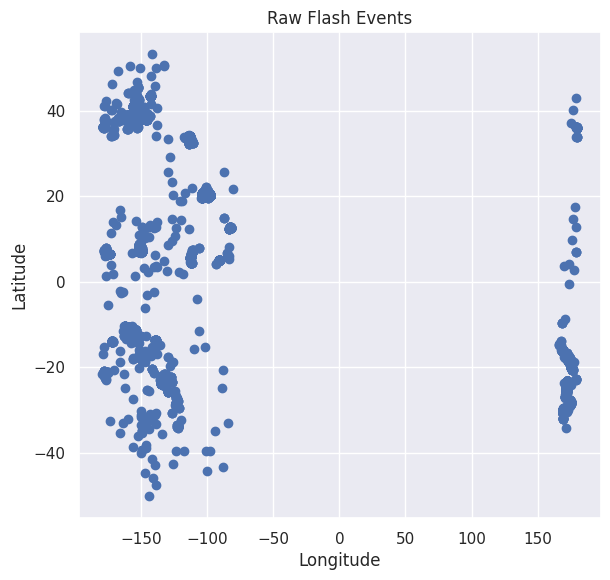

In [19]:
# 3.Raw visualization
plt.figure(figsize=(6, 6))
plt.scatter(x=geo_df['lon'], y=geo_df['lat'])
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Raw Flash Events")

In [20]:
# 4. Implement K-Means clustering algorithm
k = 12
geo_df = geo_df.loc[:, ["lon", "lat"]]
kmeans = KMeans(n_clusters=k)
geo_df["cluster"] = kmeans.fit_predict(geo_df)
geo_df["cluster"] = geo_df["cluster"].astype("category")
geo_df.head()

,lon,lat,cluster
0,-103.650860,20.465542,2
1,-175.559800,7.099273,1
2,-98.207855,20.167400,2
3,-100.783440,20.752630,2
4,-104.129340,20.865643,2


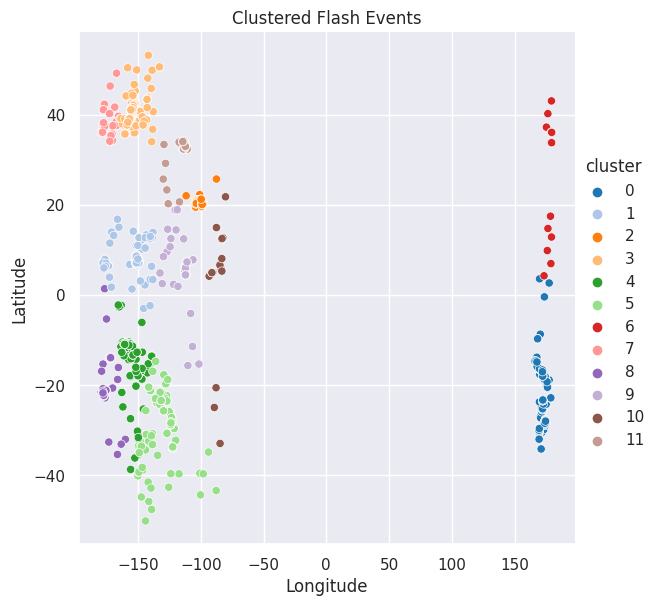

In [21]:
# Plot clusters
g = sns.relplot(
    x="lon", y="lat", hue="cluster", data=geo_df, height=6,  palette="tab20", sizes=(10, 100)
).set(title='Clustered Flash Events', xlabel="Longitude", ylabel="Latitude")

In [22]:
# 5a. Evaluate results, silhouette score
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, 24):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(geo_df)
    score = silhouette_score(geo_df, kmeans.labels_)
    silhouette_coefficients.append(score)

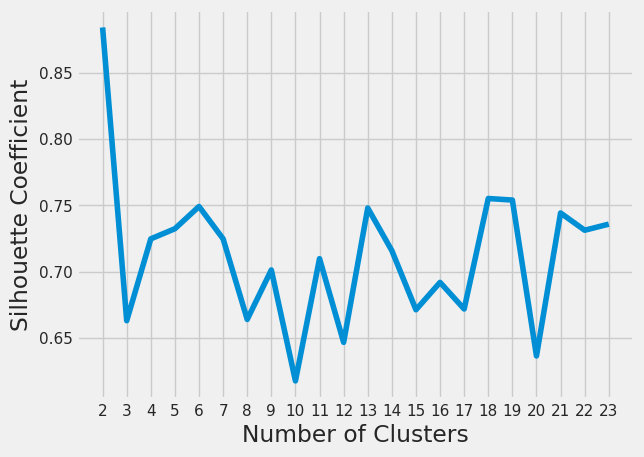

In [23]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 24), silhouette_coefficients)
plt.xticks(range(2, 24))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [24]:
# 5b. Evaluate results, elbow method
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 500,
    "random_state": 45,
}

# A list holds the sum of the squared error for each k
sse = []

# Return SSE for each k
for k in range(1, 24):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(geo_df)
    sse.append(kmeans.inertia_)

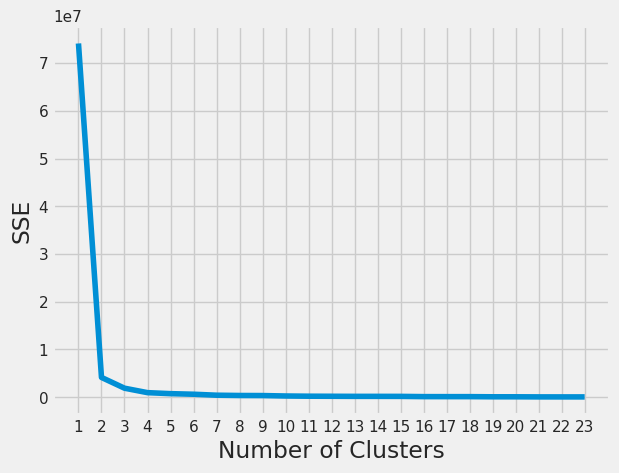

In [25]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 24), sse)
plt.xticks(range(1, 24))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [26]:
# 6. 
# load US regions shape file
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world.crs)

EPSG:4326


In [27]:
# Convert DataFrame to GeoDataFrame
geo = gpd.GeoDataFrame(geo_df, geometry=gpd.points_from_xy(geo_df.lon, geo_df.lat))

# coodinate reference system (CRS) to EPSG 4326
geo.crs = {'init': 'epsg:4326'}
geo.head()

,lon,lat,cluster,geometry
0,-103.650860,20.465542,2,POINT (-103.65086 20.46554)
1,-175.559800,7.099273,1,POINT (-175.55980 7.09927)
2,-98.207855,20.167400,2,POINT (-98.20785 20.16740)
3,-100.783440,20.752630,2,POINT (-100.78344 20.75263)
4,-104.129340,20.865643,2,POINT (-104.12934 20.86564)


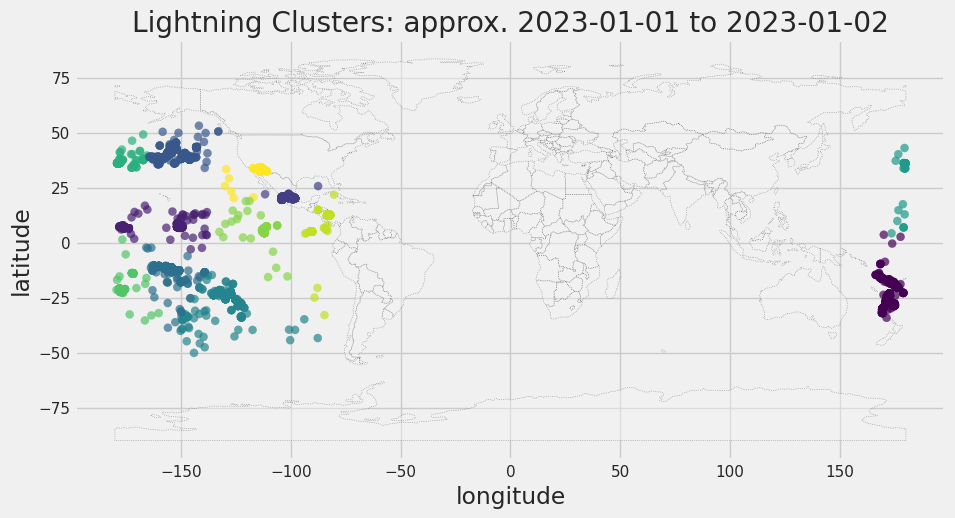

In [28]:
# plot map
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
world.plot(ax=ax, alpha=0.4, color='whitesmoke', linestyle=':', edgecolor='black', zorder=1)
geo.plot(ax=ax, column="cluster", alpha=0.7, cmap='viridis', linewidth=0.1, zorder=2)
plt.title(f"Lightning Clusters: approx. {start.date()} to {end.date()}")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()